In [46]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [44]:
!pip install dash

     ---------------------------------------- 10.3/10.3 MB 4.8 MB/s eta 0:00:00


In [47]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import pandas as pd
import plotly.graph_objs as go
from dash.dependencies import Input, Output
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [3]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10


In [4]:
df=pd.read_csv("NSE_TATA.csv")
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


In [5]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']

In [7]:
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,,
2018-10-08,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
2018-10-05,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2018-10-04,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
2018-10-03,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
2018-10-01,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


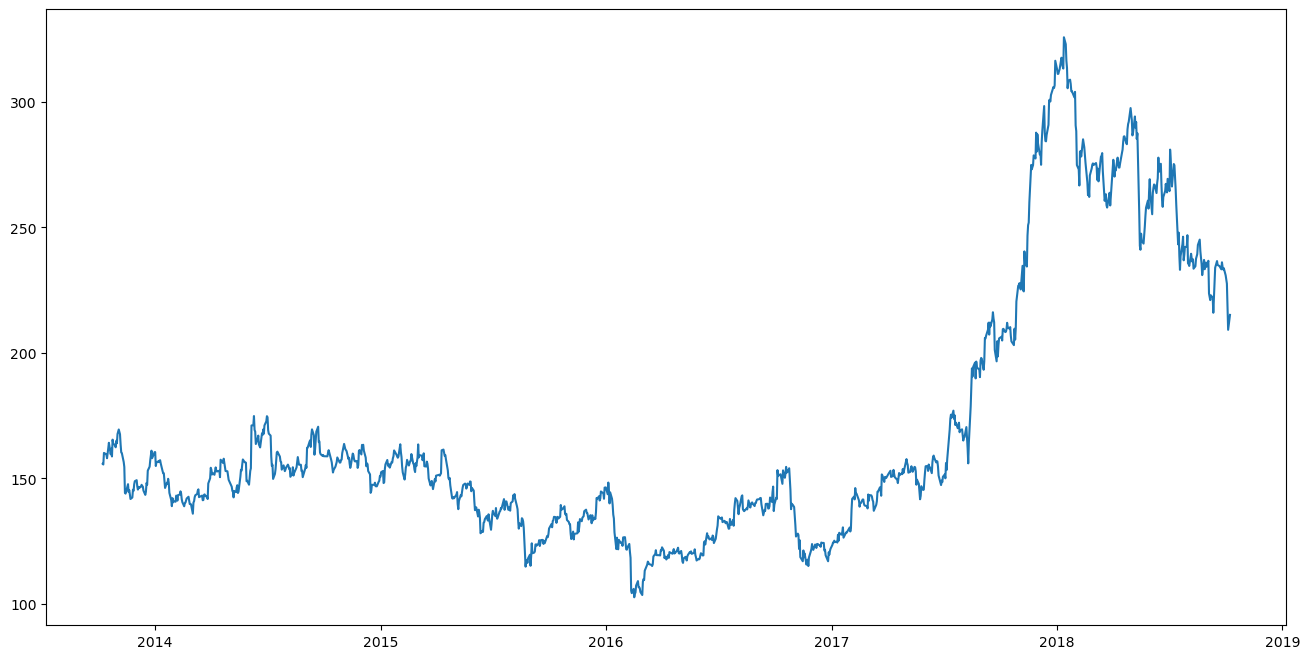

In [6]:
plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

## Model Building - LSTM Model

In [9]:
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

In [10]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

In [12]:
data.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,,
2013-10-08,2013-10-08,157.00,157.80,155.20,155.8,155.80,1720413.0,2688.94
2013-10-09,2013-10-09,155.70,158.20,154.15,155.3,155.55,2049580.0,3204.49
2013-10-10,2013-10-10,156.00,160.80,155.85,160.3,160.15,3124853.0,4978.80
2013-10-11,2013-10-11,161.15,163.45,159.00,159.8,160.05,1880046.0,3030.76
2013-10-14,2013-10-14,160.85,161.45,157.70,159.3,159.45,1281419.0,2039.09


In [13]:
for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]
    

In [14]:
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

In [15]:
new_dataset.head()

,Close
Date,
2013-10-08,155.8
2013-10-09,155.55
2013-10-10,160.15
2013-10-11,160.05
2013-10-14,159.45


In [16]:
final_dataset=new_dataset.values


In [17]:
final_dataset

array([[155.8],
       [155.55],
       [160.15],
       ...,
       [218.2],
       [209.2],
       [215.15]], dtype=object)

In [18]:
train_data=final_dataset[0:987,:]
valid_data=final_dataset[987:,:]

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

In [21]:
x_train_data,y_train_data=[],[]

In [22]:
for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])

In [23]:
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))


In [24]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

In [28]:
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

927/927 - 18s - loss: 1.8477e-04 - 18s/epoch - 20ms/step


In [29]:
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

In [30]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

In [35]:
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
prediction_closing=lstm_model.predict(X_test)
prediction_closing=scaler.inverse_transform(closing_price)

8/8 [==============================] - 0s 11ms/step


In [36]:
lstm_model.save("saved_lstm_model.h5")


In [38]:
train_data=new_dataset[:987]
valid_data=new_dataset[987:]


In [41]:
valid_data.head()

,Close,Predictions
Date,,
2017-10-09,208.3,46179.789062
2017-10-10,208.45,45992.246094
2017-10-11,209.4,45923.558594
2017-10-12,212.0,46264.425781
2017-10-13,210.25,46666.914062


In [40]:
valid_data['Predictions']=prediction_closing


C:\Users\ankit\AppData\Local\Temp\ipykernel_8520\3706322489.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=prediction_closing


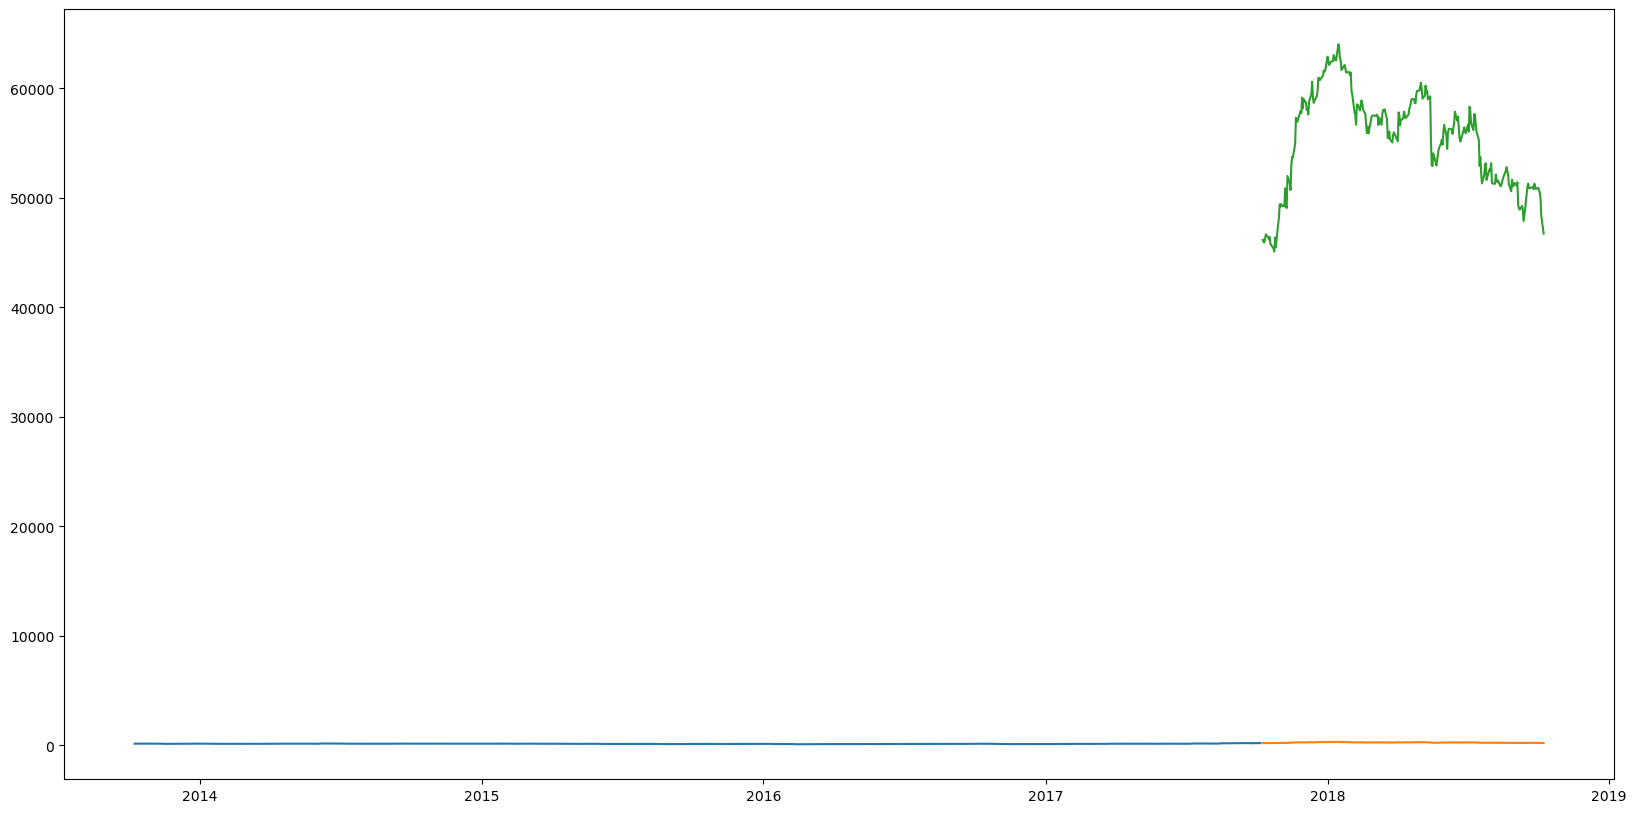

In [42]:
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])